In [1]:
import os
import tarfile
from six.moves import urllib

### get data

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

In [3]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH): 
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
fetch_housing_data()

In [4]:
ls datasets/

housing/   inception/ lifesat/


In [5]:
import pandas as pd

In [6]:
def load_housing_data(housing_path=HOUSING_PATH): 
    csv_path = os.path.join(housing_path, "housing.csv") 
    return pd.read_csv(csv_path)

In [7]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [8]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [9]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10c8288d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10ffdf400>]], dtype=object)

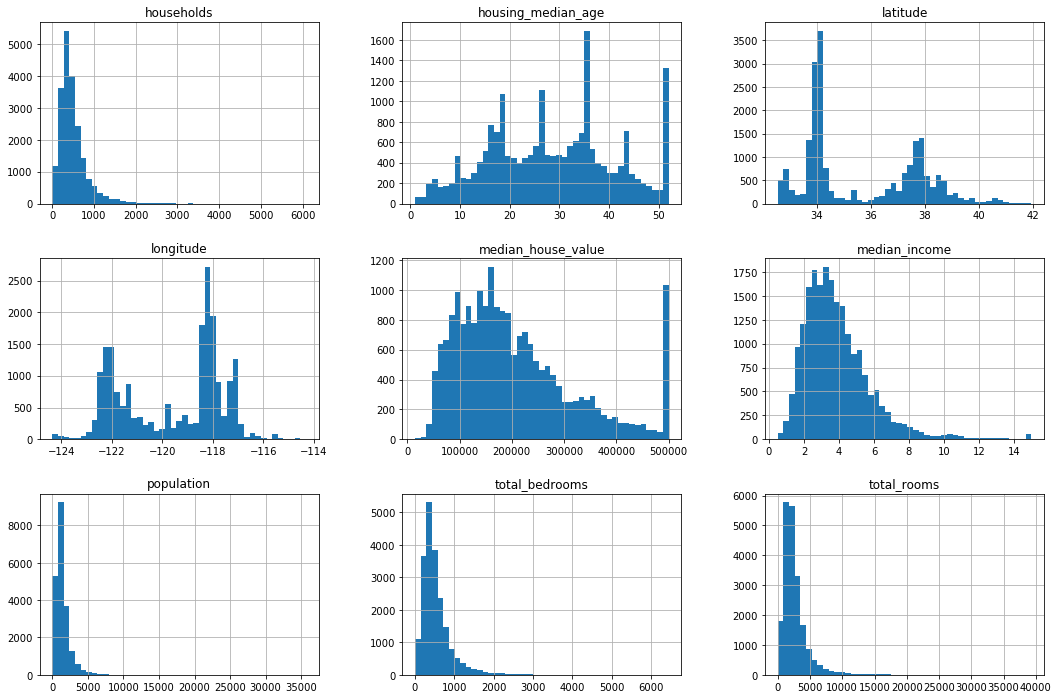

In [10]:
housing.hist(bins=45, figsize=(18,12))

In [11]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data)) 
    test_set_size = int(len(data) * test_ratio) 
    test_indices = shuffled_indices[:test_set_size] 
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(housing, 0.2)

In [12]:
import hashlib

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5): 
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash)) 
    return data.loc[~in_test_set], data.loc[in_test_set]

housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")
print(len(train_set), len(test_set))

16362 4278


In [13]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_ind, test_ind in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_ind]
    strat_test_set = housing.loc[test_ind]

In [15]:
housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [16]:
for set in (strat_train_set, strat_test_set):
    set.drop(["income_cat"], axis=1, inplace=True)

### discover and viz

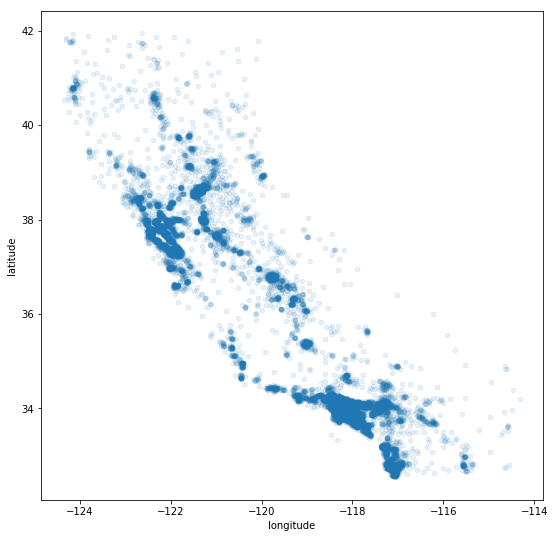

In [20]:
housing = strat_train_set.copy()

housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(9,9), alpha=0.1)

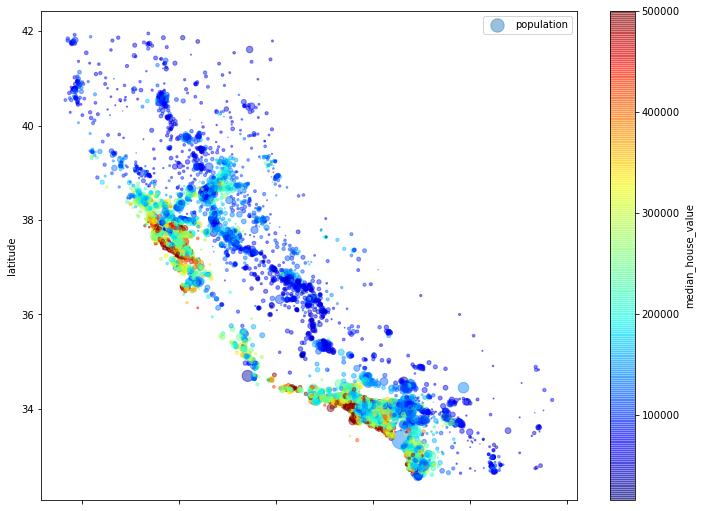

In [24]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.45,
         s=housing["population"]/100, label="population", figsize=(12,9),
         c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()

In [26]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x115287390>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x115807ac8>]], dtype=object)

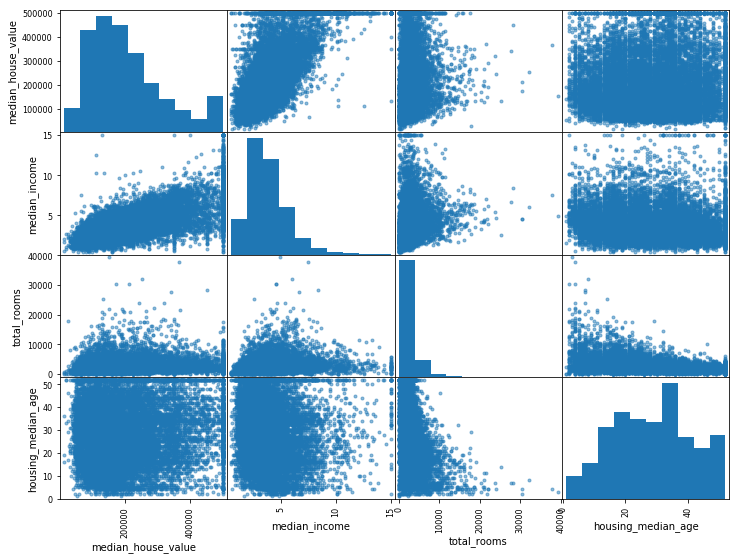

In [28]:
from pandas.tools.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 9))

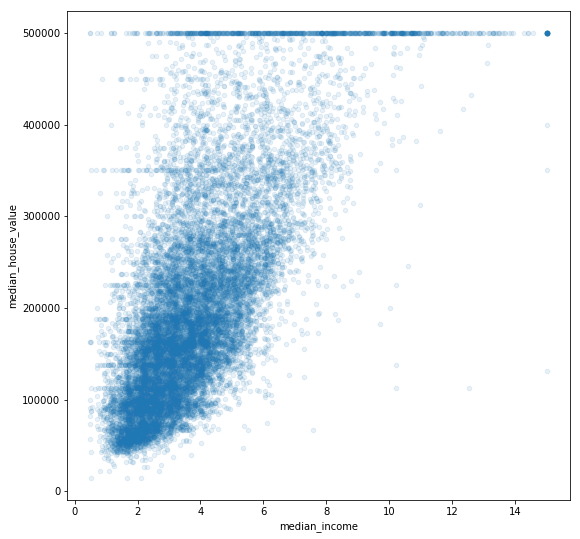

In [30]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1, figsize=(9,9))

In [32]:
# new attributes
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

### data preparation

In [33]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [34]:
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy="median")

housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [35]:
imputer.statistics_

array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

In [36]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

In [42]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([0, 0, 4, ..., 1, 0, 3])

In [43]:
print(encoder.classes_)

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


In [44]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [45]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ..., 
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

feature scaling

In [46]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6
    
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room 
    def fit(self, X, y=None):
        return self # nothing else to do 
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix] 
        population_per_household = X[:, population_ix] / X[:, household_ix] 
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [47]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', Imputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

In [52]:
from sklearn.pipeline import FeatureUnion

num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('label_binarizer', LabelBinarizer()),
])

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

In [53]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin): 
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names 
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.attribute_names].values

### Select and Train Model

In [54]:
from sklearn.linear_model import LinearRegression

housing_prepared = full_pipeline.fit_transform(housing)

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [57]:
some_data = housing.iloc[:9]
some_labels = housing_labels[:9]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:\t", lin_reg.predict(some_data_prepared))
print("Labels:\t\t", list(some_labels))

Predictions:	 [ 210644.60459286  317768.80697211  210956.43331178   59218.98886849
  189747.55849879  154295.07624519  426711.9315643   228002.94602374
  139801.43738593]
Labels:		 [286600.0, 340600.0, 196900.0, 46300.0, 254500.0, 127900.0, 500001.0, 140200.0, 95000.0]


In [58]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)

68628.1981985


In [60]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print(tree_rmse)

0.0


In [61]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=9)
rmse_scores = np.sqrt(-scores)

In [62]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
display_scores(rmse_scores)

Scores: [ 67610.43598832  72135.63380963  69106.64213811  73255.21900027
  71991.77865595  69930.9324941   68978.24411913  73155.99869066
  70512.57049766]
Mean: 70741.9394882
Standard deviation: 1884.15064778


In [63]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=9)
rmse_scores = np.sqrt(-scores)

display_scores(rmse_scores)

Scores: [ 51050.56194004  52357.37877131  51559.08797039  54586.09060737
  51878.67763066  54127.90096624  49183.46785815  55783.92016056
  52795.30477828]
Mean: 52591.3767426
Standard deviation: 1891.20709883


In [64]:
from sklearn.model_selection import GridSearchCV

param_grid = [
        {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
        {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                               scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'n_estimators': [3, 10], 'bootstrap': [False], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [65]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [66]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [67]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64683.7505836 {'n_estimators': 3, 'max_features': 2}
55682.4182546 {'n_estimators': 10, 'max_features': 2}
52889.390222 {'n_estimators': 30, 'max_features': 2}
59980.8620418 {'n_estimators': 3, 'max_features': 4}
53090.3691253 {'n_estimators': 10, 'max_features': 4}
50400.9134082 {'n_estimators': 30, 'max_features': 4}
59190.9653103 {'n_estimators': 3, 'max_features': 6}
52161.3104836 {'n_estimators': 10, 'max_features': 6}
49965.4327194 {'n_estimators': 30, 'max_features': 6}
58979.2518191 {'n_estimators': 3, 'max_features': 8}
52516.8928098 {'n_estimators': 10, 'max_features': 8}
49784.8263912 {'n_estimators': 30, 'max_features': 8}
61854.705602 {'n_estimators': 3, 'bootstrap': False, 'max_features': 2}
54795.6298929 {'n_estimators': 10, 'bootstrap': False, 'max_features': 2}
59967.5588108 {'n_estimators': 3, 'bootstrap': False, 'max_features': 3}
52354.4863751 {'n_estimators': 10, 'bootstrap': False, 'max_features': 3}
58679.7821415 {'n_estimators': 3, 'bootstrap': False, 'max_featu

In [68]:
feature_importances = grid_search.best_estimator_.feature_importances_
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_one_hot_attribs = list(encoder.classes_)
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.33644195999853621, 'median_income'),
 (0.15308689289667352, 'INLAND'),
 (0.11634595539369647, 'pop_per_hhold'),
 (0.079627449395901662, 'bedrooms_per_room'),
 (0.075062463486472109, 'longitude'),
 (0.063074679574686501, 'latitude'),
 (0.056280153244901231, 'rooms_per_hhold'),
 (0.043217326928170673, 'housing_median_age'),
 (0.015288841932732323, 'total_rooms'),
 (0.014803177095709706, 'population'),
 (0.014306467081560992, 'total_bedrooms'),
 (0.013977309350148192, 'households'),
 (0.010157140135238614, '<1H OCEAN'),
 (0.0049445518579659094, 'NEAR OCEAN'),
 (0.0033276268390630254, 'NEAR BAY'),
 (5.800478854284751e-05, 'ISLAND')]

In [69]:
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [70]:
final_rmse

47512.142312087628